# Q-learning

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import numpy as np

In [2]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

>**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [3]:
import gym

# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
env.reset()
for _ in range(10):
    # env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

state, action, reward, done, info: [ 0.04267046 -0.20729925 -0.0360248   0.27543858] 0 1.0 False {}
state, action, reward, done, info: [ 0.03852448 -0.01168233 -0.03051603 -0.02838542] 1 1.0 False {}
state, action, reward, done, info: [ 0.03829083  0.18386365 -0.03108374 -0.33053814] 1 1.0 False {}
state, action, reward, done, info: [ 0.0419681  -0.01080236 -0.0376945  -0.04781734] 0 1.0 False {}
state, action, reward, done, info: [ 0.04175206  0.18483926 -0.03865085 -0.35215086] 1 1.0 False {}
state, action, reward, done, info: [ 0.04544884  0.38048892 -0.04569387 -0.65676669] 1 1.0 False {}
state, action, reward, done, info: [ 0.05305862  0.57621617 -0.0588292  -0.96348044] 1 1.0 False {}
state, action, reward, done, info: [ 0.06458294  0.77207709 -0.07809881 -1.27404938] 1 1.0 False {}
state, action, reward, done, info: [ 0.08002448  0.96810368 -0.1035798  -1.59013071] 1 1.0 False {}
state, action, reward, done, info: [ 0.09938656  1.16429199 -0.13538241 -1.91323398] 1 1.0 False {}


To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
# print(rewards[-20:])
# print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
# print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
# print(np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
# print(np.max(np.array(rewards)), np.min(np.array(rewards)))
# print(np.max(np.array(states)), np.min(np.array(states)))

The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [6]:
# Data of the model
def model_input(state_size, lstm_size, batch_size):
    # Current states and actions for calculating Qs
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    
    # Calculated targetQs
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    
    # GRU: Gated Recurrent Units
    gru = tf.nn.rnn_cell.GRUCell(lstm_size)
    cell = tf.nn.rnn_cell.MultiRNNCell([gru], state_is_tuple=False)
    initial_state = cell.zero_state(batch_size, tf.float32)
    
    # returning the given data to the model
    return states, actions, targetQs, cell, initial_state

In [7]:
# RNN generator or sequence generator
def generator(lstm_size, batch_size, num_classes, inputs, initial_state, cell, reuse=False): 
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=inputs, units=lstm_size)
        print(inputs.shape ,h1.shape)
        
        # with tf.variable_scope('dynamic_rnn_', reuse=tf.AUTO_REUSE):
        inputs_rnn = tf.reshape(h1, [1, batch_size, lstm_size]) # 1xNxH
        print(inputs_rnn.shape, initial_state.shape)
        outputs_rnn, final_state = tf.nn.dynamic_rnn(cell=cell, inputs=inputs_rnn, initial_state=initial_state)
        print(outputs_rnn.shape, final_state.shape)
        outputs = tf.reshape(outputs_rnn, [-1, lstm_size]) # NxH
        print(outputs.shape)

        # Last fully connected layer
        logits = tf.layers.dense(inputs=outputs, units=num_classes)
        print(logits.shape)
        #predictions = tf.nn.softmax(logits)
        
        # logits are the action logits
        return logits, final_state

In [8]:
def model_loss(num_classes, lstm_size, batch_size, 
               inputs, targetQs, cell, initial_state, actions):
    # Build rnncell and initilize it
    actions_logits, final_state = generator(inputs=inputs, cell=cell, initial_state=initial_state,
                                            batch_size=batch_size, lstm_size=lstm_size, num_classes=num_classes)

    # # Calculating Qs using NEW memory using actions
    # Onehot vectorizing the actions logits
    actions_onehot = tf.one_hot(indices=actions, depth=num_classes, dtype=actions_logits.dtype)
    Qs_onehot = tf.multiply(actions_logits[:-1], actions_onehot[1:])
    Qs = tf.reduce_max(Qs_onehot, axis=1)
    
    # Calculating the loss: logits/predictions vs labels
    loss = tf.reduce_mean(tf.square(Qs - targetQs[1:]))
    #loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs, labels=tf.nn.sigmoid(targetQs[1:])))
    
    return actions_logits, loss, final_state

In [9]:
def model_opt(loss, learning_rate):
    """
    Get optimization operations in order
    :param loss: Generator loss Tensor for action prediction
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # # Optimize
    # with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
    # #opt = tf.train.AdamOptimizer(learning_rate).minimize(loss, var_list=g_vars)

    grads, _ = tf.clip_by_global_norm(t_list=tf.gradients(loss, g_vars), clip_norm=5) # usually around 1-5
    #grads=tf.gradients(loss, g_vars)

    train_op = tf.train.AdamOptimizer(learning_rate)
    opt = train_op.apply_gradients(grads_and_vars=zip(grads, g_vars))

    return opt

In [10]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, batch_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, cell, self.initial_state = model_input(
            state_size=state_size, batch_size=1, lstm_size=hidden_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.loss, self.final_state = model_loss(
            num_classes=action_size, lstm_size=hidden_size, batch_size=batch_size,
            inputs=self.states, actions=self.actions, targetQs=self.targetQs, 
            cell=cell, initial_state=self.initial_state)

        # Update the model: backward pass and backprop
        self.opt = model_opt(loss=self.loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [11]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [13]:
# print('state:', np.array(states).shape[1], 
#       'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

In [14]:
# Training parameters
train_episodes = 1000          # max number of episodes to learn from
max_steps = 200000000          # max steps in an episode
learning_rate = 0.001          # learning rate for adam

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation
action_size = 2                # number of units for the output actions -- simulation
batch_size = 500               # number of samples in the memory/ experience as mini-batch size

In [15]:
# Reset/init the graph/session
tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, batch_size=batch_size, 
              learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=batch_size)

(?, 4) (?, 64)
(1, 500, 64) (1, 64)
(1, 500, 64) (1, 64)
(500, 64)
(500, 2)


## Populate the memory (exprience memory)

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [16]:
# Initialize the simulation
env.reset()

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    
    # Take one random step to get the pole and cart moving
    action = env.action_space.sample()
    state, _, done, _ = env.step(action)
    reward = 1 - float(done)
    memory.buffer.append((action, state, reward))
    
    # End of the episodes which defines the goal of the episode/mission
    if done is True:
        # Start new episode
        env.reset()

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [17]:
memory.buffer[0][1].shape

(4,)

In [19]:
# states, rewards, actions

In [20]:
# Now train with experiences
saver = tf.train.Saver()

# Total rewards and losses list for plotting after training session/graph
rewards_list = [] # accuracy
loss_list = [] # loss

# TF session for training
with tf.Session() as sess:
    
    # Initialize/restore variables
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))

    # RNN state initialize for all episodes
    initial_state = sess.run(model.initial_state) # Qs or current batch or states[:-1]
    
    # Explore or exploit parameter
    total_step = 0
    
    # Training episodes/epochs
    for ep in range(train_episodes):
        
        # Start new episode
        env.reset()
        total_reward = 0
        loss_batch = []

        # Training steps/batches
        for _ in range(max_steps): # start=0, step=1, stop=max_steps/done/reward
            
            # Batch from the OLD memory
            batch = memory.buffer
            states = np.array([each[1] for each in batch])
            
            # Calculating next action using OLD memory
            feed_dict = {model.states: states, model.initial_state: initial_state}
            actions_logits, final_state = sess.run([model.actions_logits, model.final_state], feed_dict)
            last_action_logits = actions_logits[-1]
            
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from model
                action = np.argmax(last_action_logits)
            
            # Take new action, get new state and reward
            state, _, done, _ = env.step(action)
            reward = 1 - float(done)
            
            # New memory (time direction)
            memory.buffer.append((action, state, reward))
            
            # Feedback loop/connection for NEW memory
            initial_state = final_state
            
            # Cumulative rewards
            total_reward += reward

            # Batch from the NEW memory
            batch = memory.buffer
            actions = np.array([each[0] for each in batch])
            states = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])

            # Calculating nextQs using NEW memory
            feed_dict = {model.states: states, model.initial_state: initial_state}
            actions_logits = sess.run(model.actions_logits, feed_dict)
            rewarded_actions_logits = np.multiply(actions_logits, rewards.reshape([-1, 1]))
            Qs = np.max(rewarded_actions_logits, axis=1)

            # Updating the model using NEW memory and targetQs/nextQs
            feed_dict = {model.states: states, 
                         model.actions: actions, 
                         model.targetQs: Qs, 
                         model.initial_state: initial_state}
            loss, _ = sess.run([model.loss, model.opt], feed_dict)
            
            # For average loss in one episode/epoch
            loss_batch.append(loss)
            
            # At the end of steps/batches loop
            if done is True:
                break
                
        # At the end of each episode/epoch
        print('-------------------------------------------------------------------------------')
        print('Episode: {}'.format(ep),
              'Total reward: {}'.format(total_reward),
              'Average loss: {:.4f}'.format(np.mean(loss_batch)),
              'Explore P: {:.4f}'.format(explore_p))
        print('-------------------------------------------------------------------------------')

        # At the end of each episode/epoch
        # total rewards and losses for plotting
        rewards_list.append((ep, total_reward))
        loss_list.append((ep, np.mean(loss_batch)))
        
    # At the end of all training episodes/epochs
    # Save the trained model
    saver.save(sess, 'checkpoints/model-seq.ckpt')

-------------------------------------------------------------------------------
Episode: 0 Total reward: 14.0 Average loss: 0.0131 Explore P: 0.9985
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1 Total reward: 19.0 Average loss: 0.0238 Explore P: 0.9965
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2 Total reward: 12.0 Average loss: 0.0117 Explore P: 0.9953
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3 Total reward: 15.0 Average loss: 0.0107 Explore P: 0.9937
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Epis

-------------------------------------------------------------------------------
Episode: 36 Total reward: 18.0 Average loss: 0.0015 Explore P: 0.9221
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 37 Total reward: 10.0 Average loss: 0.0020 Explore P: 0.9211
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 38 Total reward: 22.0 Average loss: 0.0026 Explore P: 0.9190
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 39 Total reward: 25.0 Average loss: 0.0032 Explore P: 0.9166
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------


-------------------------------------------------------------------------------
Episode: 72 Total reward: 32.0 Average loss: 18.4808 Explore P: 0.8347
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 73 Total reward: 85.0 Average loss: 18.0280 Explore P: 0.8276
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 74 Total reward: 32.0 Average loss: 15.5818 Explore P: 0.8249
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 75 Total reward: 56.0 Average loss: 18.7682 Explore P: 0.8203
-------------------------------------------------------------------------------
----------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 108 Total reward: 55.0 Average loss: 21.2735 Explore P: 0.7432
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 109 Total reward: 63.0 Average loss: 26.3451 Explore P: 0.7385
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 110 Total reward: 12.0 Average loss: 62.9240 Explore P: 0.7376
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 111 Total reward: 18.0 Average loss: 24.8963 Explore P: 0.7362
-------------------------------------------------------------------------------
------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 144 Total reward: 88.0 Average loss: 25.3718 Explore P: 0.6469
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 145 Total reward: 18.0 Average loss: 49.6576 Explore P: 0.6457
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 146 Total reward: 24.0 Average loss: 53.1698 Explore P: 0.6441
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 147 Total reward: 106.0 Average loss: 33.1176 Explore P: 0.6374
-------------------------------------------------------------------------------
-----------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 180 Total reward: 186.0 Average loss: 54.3273 Explore P: 0.5270
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 181 Total reward: 28.0 Average loss: 93.9315 Explore P: 0.5255
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 182 Total reward: 99.0 Average loss: 118.4929 Explore P: 0.5204
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 183 Total reward: 77.0 Average loss: 68.9544 Explore P: 0.5164
-------------------------------------------------------------------------------
----------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 216 Total reward: 60.0 Average loss: 2163.7561 Explore P: 0.3950
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 217 Total reward: 11.0 Average loss: 1093.0175 Explore P: 0.3945
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 218 Total reward: 10.0 Average loss: 801.9543 Explore P: 0.3941
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 219 Total reward: 10.0 Average loss: 511.0623 Explore P: 0.3937
-------------------------------------------------------------------------------
------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 252 Total reward: 142.0 Average loss: 473.1607 Explore P: 0.2479
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 253 Total reward: 161.0 Average loss: 270.4555 Explore P: 0.2441
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 254 Total reward: 199.0 Average loss: 2328.5928 Explore P: 0.2394
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 255 Total reward: 24.0 Average loss: 3465.7419 Explore P: 0.2389
-------------------------------------------------------------------------------
---------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 288 Total reward: 199.0 Average loss: 314.8618 Explore P: 0.1521
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 289 Total reward: 199.0 Average loss: 304.6776 Explore P: 0.1493
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 290 Total reward: 199.0 Average loss: 368.8920 Explore P: 0.1466
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 291 Total reward: 199.0 Average loss: 272.9488 Explore P: 0.1439
-------------------------------------------------------------------------------
----------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 324 Total reward: 199.0 Average loss: 1649.9056 Explore P: 0.1009
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 325 Total reward: 41.0 Average loss: 447.7471 Explore P: 0.1006
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 326 Total reward: 199.0 Average loss: 481.8444 Explore P: 0.0988
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 327 Total reward: 94.0 Average loss: 290.8911 Explore P: 0.0979
-------------------------------------------------------------------------------
-----------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 360 Total reward: 199.0 Average loss: 493.0004 Explore P: 0.0781
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 361 Total reward: 145.0 Average loss: 402.9657 Explore P: 0.0772
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 362 Total reward: 34.0 Average loss: 425.1487 Explore P: 0.0769
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 363 Total reward: 130.0 Average loss: 446.7404 Explore P: 0.0761
-------------------------------------------------------------------------------
-----------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 396 Total reward: 199.0 Average loss: 179.1374 Explore P: 0.0600
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 397 Total reward: 177.0 Average loss: 116.3407 Explore P: 0.0591
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 398 Total reward: 77.0 Average loss: 201.8150 Explore P: 0.0587
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 399 Total reward: 199.0 Average loss: 209.3655 Explore P: 0.0578
-------------------------------------------------------------------------------
-----------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 432 Total reward: 27.0 Average loss: 424.5907 Explore P: 0.0462
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 433 Total reward: 27.0 Average loss: 492.7043 Explore P: 0.0461
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 434 Total reward: 56.0 Average loss: 436.2191 Explore P: 0.0459
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 435 Total reward: 26.0 Average loss: 383.4921 Explore P: 0.0458
-------------------------------------------------------------------------------
--------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 468 Total reward: 199.0 Average loss: 294.7498 Explore P: 0.0338
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 469 Total reward: 199.0 Average loss: 325.3604 Explore P: 0.0334
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 470 Total reward: 199.0 Average loss: 229.0334 Explore P: 0.0329
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 471 Total reward: 199.0 Average loss: 298.8789 Explore P: 0.0324
-------------------------------------------------------------------------------
----------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 504 Total reward: 18.0 Average loss: 559.6883 Explore P: 0.0235
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 505 Total reward: 199.0 Average loss: 568.1539 Explore P: 0.0233
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 506 Total reward: 199.0 Average loss: 487.2603 Explore P: 0.0230
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 507 Total reward: 199.0 Average loss: 418.9383 Explore P: 0.0227
-------------------------------------------------------------------------------
-----------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 540 Total reward: 40.0 Average loss: 527.5221 Explore P: 0.0187
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 541 Total reward: 199.0 Average loss: 306.3706 Explore P: 0.0185
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 542 Total reward: 199.0 Average loss: 218.3201 Explore P: 0.0184
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 543 Total reward: 199.0 Average loss: 418.0095 Explore P: 0.0182
-------------------------------------------------------------------------------
-----------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 576 Total reward: 199.0 Average loss: 191.3952 Explore P: 0.0155
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 577 Total reward: 87.0 Average loss: 172.2764 Explore P: 0.0155
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 578 Total reward: 199.0 Average loss: 281.9355 Explore P: 0.0153
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 579 Total reward: 150.0 Average loss: 413.8507 Explore P: 0.0153
-------------------------------------------------------------------------------
-----------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 612 Total reward: 12.0 Average loss: 2068.5955 Explore P: 0.0136
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 613 Total reward: 11.0 Average loss: 1809.5210 Explore P: 0.0136
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 614 Total reward: 199.0 Average loss: 1321.7405 Explore P: 0.0135
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 615 Total reward: 199.0 Average loss: 510.7973 Explore P: 0.0134
-------------------------------------------------------------------------------
---------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 648 Total reward: 36.0 Average loss: 241.5256 Explore P: 0.0121
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 649 Total reward: 139.0 Average loss: 252.5147 Explore P: 0.0120
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 650 Total reward: 92.0 Average loss: 162.6839 Explore P: 0.0120
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 651 Total reward: 199.0 Average loss: 130.6704 Explore P: 0.0120
-------------------------------------------------------------------------------
------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 684 Total reward: 13.0 Average loss: 570.0346 Explore P: 0.0111
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 685 Total reward: 30.0 Average loss: 550.9927 Explore P: 0.0111
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 686 Total reward: 171.0 Average loss: 417.1372 Explore P: 0.0111
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 687 Total reward: 145.0 Average loss: 443.7315 Explore P: 0.0111
-------------------------------------------------------------------------------
------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 720 Total reward: 77.0 Average loss: 193.1374 Explore P: 0.0107
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 721 Total reward: 199.0 Average loss: 222.0381 Explore P: 0.0107
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 722 Total reward: 154.0 Average loss: 216.7390 Explore P: 0.0107
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 723 Total reward: 76.0 Average loss: 245.0175 Explore P: 0.0107
-------------------------------------------------------------------------------
------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 756 Total reward: 14.0 Average loss: 858.4295 Explore P: 0.0105
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 757 Total reward: 15.0 Average loss: 925.2332 Explore P: 0.0105
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 758 Total reward: 14.0 Average loss: 871.4645 Explore P: 0.0105
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 759 Total reward: 13.0 Average loss: 877.1591 Explore P: 0.0105
-------------------------------------------------------------------------------
--------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 792 Total reward: 55.0 Average loss: 361.0142 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 793 Total reward: 199.0 Average loss: 272.2151 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 794 Total reward: 199.0 Average loss: 418.2545 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 795 Total reward: 137.0 Average loss: 397.1387 Explore P: 0.0103
-------------------------------------------------------------------------------
-----------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 828 Total reward: 39.0 Average loss: 332.2992 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 829 Total reward: 199.0 Average loss: 240.6809 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 830 Total reward: 199.0 Average loss: 188.6413 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 831 Total reward: 199.0 Average loss: 152.8137 Explore P: 0.0102
-------------------------------------------------------------------------------
-----------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 864 Total reward: 20.0 Average loss: 65.1219 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 865 Total reward: 43.0 Average loss: 96.8648 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 866 Total reward: 199.0 Average loss: 84.7105 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 867 Total reward: 199.0 Average loss: 128.0795 Explore P: 0.0101
-------------------------------------------------------------------------------
---------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 900 Total reward: 14.0 Average loss: 532.3405 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 901 Total reward: 10.0 Average loss: 562.4816 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 902 Total reward: 14.0 Average loss: 475.0743 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 903 Total reward: 45.0 Average loss: 399.0385 Explore P: 0.0101
-------------------------------------------------------------------------------
--------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 936 Total reward: 44.0 Average loss: 76.9893 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 937 Total reward: 37.0 Average loss: 151.1872 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 938 Total reward: 31.0 Average loss: 157.1638 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 939 Total reward: 13.0 Average loss: 132.9010 Explore P: 0.0101
-------------------------------------------------------------------------------
---------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 972 Total reward: 11.0 Average loss: 189.7690 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 973 Total reward: 13.0 Average loss: 177.5767 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 974 Total reward: 12.0 Average loss: 180.8317 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 975 Total reward: 104.0 Average loss: 160.4033 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

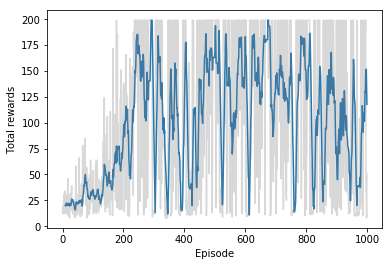

In [22]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Average losses')

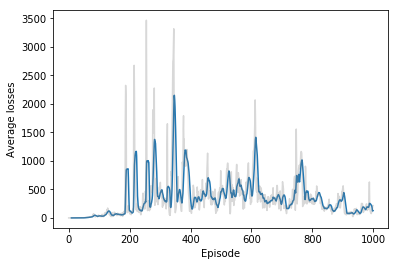

In [23]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Average losses')

## Testing

Let's checkout how our trained agent plays the game.

In [24]:
# import gym

# # Create the Cart-Pole game environment
# env = gym.make('CartPole-v0')
# # env = gym.make('CartPole-v1')
# # env = gym.make('Acrobot-v1')
# # env = gym.make('MountainCar-v0')
# # env = gym.make('Pendulum-v0')
# # env = gym.make('Blackjack-v0')
# # env = gym.make('FrozenLake-v0')
# # env = gym.make('AirRaid-ram-v0')
# # env = gym.make('AirRaid-v0')
# # env = gym.make('BipedalWalker-v2')
# # env = gym.make('Copy-v0')
# # env = gym.make('CarRacing-v0')
# # env = gym.make('Ant-v2') #mujoco
# # env = gym.make('FetchPickAndPlace-v1') # mujoco required!

# test_episodes = 1
# test_max_steps = 20000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

# with tf.Session() as sess:
    
#     # Initialize/restore/load the trained model 
#     #saver.restore(sess, 'checkpoints/QGAN-cartpole.ckpt')    
#     saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
#     # iterations
#     for ep in range(test_episodes):

#         # Take one random step to get the pole and cart moving
#         env.reset()
#         state, _, _, _ = env.step(env.action_space.sample())
#         initial_state = sess.run(model.initial_state) # Qs or current batch or states[:-1]

        
#         # number of env/rob steps
#         for _ in range(test_max_steps):
            
#             # Rendering the env graphics
#             env.render()
            
#             # Get action from DQAN
#             feed_dict = {model.states: state.reshape((1, *state.shape)), model.initial_state: initial_state}
#             actions_logits, final_state = sess.run([model.actions_logits, model.final_state], feed_dict)
#             action = np.argmax(actions_logits)
#             initial_state = final_state
            
#             # Take action, get new state and reward
#             state, _, done, _ = env.step(action)
            
#             # The task is done or not;
#             if done:
#                 break
                
# # Closing the env
# env.close()

## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.